- For our positive controls, ideally we’d like to establish a reference ORF paired with two mutants, one showing strong shifts and one subtle in the protein channel as well as detectable changes in morphology. In this case, profiling would especially be helpful. For the NegCons, we must slim down our selection to only 4 ORFs – I’m not sure if you guys have preference for selection there.


- Regarding the PosCons, we’d like to select either IMPDH1 or ALK as our reference allele, 
  plus two of their respective variants (one which shows strong morphological shifts/localization patterns,
  and one that’s subtle). For NegCons, we can only select 4 to include in our screen – 
  I’ll leave it up to you guys which 4 best suit your needs.


- You can disregard all wells that are not labelled either PosCon or NegCon for this screen. 
  And please keep in mind each quadrant received a varying dose of viral supernatant. 
  The amount I settled on for our final pipeline is 6 uL, so perhaps you want to pay attention to the wells which     received a vTitre = 6.


In [174]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import sklearn.preprocessing as sp
import pickle
# from imblearn.over_sampling import SMOTE  
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import os

from scipy.stats import pearsonr
import scipy
from matplotlib import rcParams
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, '/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
from singlecell.preprocess import handle_nans, extract_cpfeature_names

import sys
sys.path.insert(0, '/home/ubuntu/workspace_rare/2017_09_27_RareDiseases_Taipale/') 
from utils import preprocessing,meanProfileAnalysis,visualization,impactscore
from datetime import date
today = date.today()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Read cleaned metadata from "metadata/reprocessed" folder

In [175]:
# rootDir='/home/ubuntu/bucket/projects/2017_10_19_Profiling_rare_ORFs/workspace/'
rootDir='/home/ubuntu/bucket/projects/2021_09_01_VarCHAMP/workspace/'
# batch='2022_08_22_Batch_1'
batch='2023_02_23_Batch_3'
annot_df=pd.read_csv(rootDir+'/metadata/reprocessed/'+batch+'.csv')
annot_df.head()

,Metadata_Well,384_ID,entryID,Symbol,entry_plate.x,entry_well.x,entry_numb,dest_plate_96,dest_well_96,dest_numb_96,...,r384,c384,Metadata_Plate,batch,control,Gene,MT,Variant,Metadata_Sample_Unique,Metadata_batch_Plate
0,A01,1_1,DisWTGDEh03_F06,ACSF3,DisWTGDEh03,F06,46.0,FVrry_P01_Q01,A01,1.0,...,1.0,1.0,2022_10_11_PPL9_P1,2023_02_23_Batch_3,False,ACSF3,NaN,ACSF3,ACSF3,2023_02_23_Batch_3-2022_10_11_PPL9_P1
1,C01,3_1,VUSmut_GDEh03_A02,ACSF3,VUSmut_GDEh03,A02,9.0,FVrry_P01_Q01,B01,2.0,...,3.0,1.0,2022_10_11_PPL9_P1,2023_02_23_Batch_3,False,ACSF3,Ala197Thr,ACSF3 Ala197Thr,ACSF3 Ala197Thr,2023_02_23_Batch_3-2022_10_11_PPL9_P1
2,E01,5_1,VUSmut_GDEh03_A03,ACSF3,VUSmut_GDEh03,A03,17.0,FVrry_P01_Q01,C01,3.0,...,5.0,1.0,2022_10_11_PPL9_P1,2023_02_23_Batch_3,False,ACSF3,Thr358Ile,ACSF3 Thr358Ile,ACSF3 Thr358Ile,2023_02_23_Batch_3-2022_10_11_PPL9_P1
3,G01,7_1,VUSmut_GDEh03_B02,ACSF3,VUSmut_GDEh03,B02,10.0,FVrry_P01_Q01,D01,4.0,...,7.0,1.0,2022_10_11_PPL9_P1,2023_02_23_Batch_3,False,ACSF3,Met198Arg,ACSF3 Met198Arg,ACSF3 Met198Arg,2023_02_23_Batch_3-2022_10_11_PPL9_P1
4,I01,9_1,VUSmut_GDEh03_B03,ACSF3,VUSmut_GDEh03,B03,18.0,FVrry_P01_Q01,E01,5.0,...,9.0,1.0,2022_10_11_PPL9_P1,2023_02_23_Batch_3,False,ACSF3,Glu359Lys,ACSF3 Glu359Lys,ACSF3 Glu359Lys,2023_02_23_Batch_3-2022_10_11_PPL9_P1


In [207]:
# annot_df['Gene'].unique()

In [185]:
def read_per_well_data_csvs(input_data_dir,annot,profile_type):
    batches=annot['batch'].unique()
    
    df_agg_all_batches_ls=[]
    for b in batches:
        print(b)
        df_sag_ls=[]
        plates_exist=os.listdir(input_data_dir+'/profiles/'+b)
        plates_meta=annot.loc[annot['batch']==b,'Metadata_Plate'].unique()
        plates=set(plates_meta) & set(plates_exist)
#         print(plates_meta, plates_exist)
        for p in plates:
            print(p)
            
            fileName=input_data_dir+'/profiles/'+b+'/'+p+'/'+p+''+profile_type+'.csv.gz'
            print(fileName)
            if os.path.exists(fileName):
                sc_df=pd.read_csv(fileName,compression='gzip')

        #         per_site_aggregate=sc_df.groupby(['Metadata_Well','Metadata_Site']).mean()[feature_list+['Count_Cells']].reset_index()
                sc_df['Metadata_Batch']=b
                sc_df['Metadata_Plate']=p
                df_sag_ls.append(sc_df)
                del sc_df
#                 gc.collect()
            else:
                print(fileName,' not exists')

        if df_sag_ls:
            df_sag=pd.concat(df_sag_ls,axis=0)
            df_agg_all_batches_ls.append(df_sag)

    df_agg_all_batches=pd.concat(df_agg_all_batches_ls,axis=0)
    return df_agg_all_batches

In [78]:
# profiles_path = '/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace'


In [81]:
# df_agg_all_batches['Metadata_Plate']

#### 5. Load and preprocess replicate level profiles

In [186]:
profile_type = '_normalized_feature_select_batch'
df_agg_all_batches=read_per_well_data_csvs(rootDir,annot_df,profile_type);

prot_ch_suffix='GFP'

cp_features, cp_features_analysis = extract_cpfeature_names.extract_cpfeature_names(df_agg_all_batches);
#   df_batch_plates, cp_features_analysis_batch = handle_nans.handle_nans(df,cp_features_analysis,\
#                                                    thrsh_null_ratio=0.05,fill_na_method='drop-rows');  

df_batch_plates, cp_features_analysis_batch = handle_nans.handle_nans(df_agg_all_batches,cp_features_analysis,\
                                               thrsh_null_ratio=0);  

cpFeats_P=[p for p in cp_features_analysis_batch if prot_ch_suffix in p]
cpFeats_NP=[p for p in cp_features_analysis_batch if (prot_ch_suffix not in p)]
print(len(cpFeats_P),len(cpFeats_NP))

cols_to_use = annot_df.columns.difference(df_batch_plates.columns).tolist()
df_batch_plates_annot=pd.merge(df_batch_plates, annot_df[cols_to_use+['Metadata_Plate','Metadata_Well']],\
                                 how='inner',on=['Metadata_Plate','Metadata_Well']);

# df_scaled_annot,cpFeats_A,cpFeats_P,cpFeats_NP=\
# meanProfileAnalysis.read_merge_preprocess_meanProfiles(annot_df,read_pop_params);

# # dfTransSummary = df_scaled_annot[['Metadata_batch_Plate','Metadata_Sample_Unique','n_transf','n_untransf','transf_Ratio']]
# dfTransSummary=df_scaled_annot[annot_df.columns.tolist()+['n_transf','n_untransf','transf_Ratio']];


2023_02_23_Batch_3
2022_10_11_PPL9_P1
/home/ubuntu/bucket/projects/2021_09_01_VarCHAMP/workspace//profiles/2023_02_23_Batch_3/2022_10_11_PPL9_P1/2022_10_11_PPL9_P1_normalized_feature_select_batch.csv.gz
2022_09_29_PPL9_P2
/home/ubuntu/bucket/projects/2021_09_01_VarCHAMP/workspace//profiles/2023_02_23_Batch_3/2022_09_29_PPL9_P2/2022_09_29_PPL9_P2_normalized_feature_select_batch.csv.gz
2022_09_29_PPL9_P3
/home/ubuntu/bucket/projects/2021_09_01_VarCHAMP/workspace//profiles/2023_02_23_Batch_3/2022_09_29_PPL9_P3/2022_09_29_PPL9_P3_normalized_feature_select_batch.csv.gz
cp_features: 680
cols2remove_manyNulls ['Cells_Neighbors_AngleBetweenNeighbors_30']
cols2remove_lowVars []
len cp_features_analysis/nan cols/low vars: 679 1 0
95 584


In [90]:
# df_batch_plates['batch']
# print(cols_to_use)

['384_ID', 'Gene', 'MT', 'Metadata_Sample_Unique', 'Symbol', 'Variant', 'aa_ch2', 'aa_change', 'batch', 'c384', 'c96', 'chr', 'chr_pos_37', 'chr_pos_38', 'control', 'dest_numb_96', 'dest_plate_96', 'dest_well_96', 'ensg', 'entryID', 'entry_numb', 'entry_plate.x', 'entry_well.x', 'mutation_id', 'node_type', 'nt_change', 'orf_id', 'r384', 'r96']


In [125]:
df_batch_plates_annot['Metadata_batch_Plate']
# df_batch_plates_annot[df_batch_plates_annot['Metadata_Sample_Unique']=='516 - TC ']

0       2023_02_23_Batch_3-2022_10_11_PPL9_P1
1       2023_02_23_Batch_3-2022_10_11_PPL9_P1
2       2023_02_23_Batch_3-2022_10_11_PPL9_P1
3       2023_02_23_Batch_3-2022_10_11_PPL9_P1
4       2023_02_23_Batch_3-2022_10_11_PPL9_P1
                        ...                  
1144    2023_02_23_Batch_3-2022_09_29_PPL9_P3
1145    2023_02_23_Batch_3-2022_09_29_PPL9_P3
1146    2023_02_23_Batch_3-2022_09_29_PPL9_P3
1147    2023_02_23_Batch_3-2022_09_29_PPL9_P3
1148    2023_02_23_Batch_3-2022_09_29_PPL9_P3
Name: Metadata_batch_Plate, Length: 1149, dtype: object

In [188]:
df_batch_plates_annot[df_batch_plates_annot['Metadata_Sample_Unique']!='516 - TC'].reset_index(drop=True)

,Metadata_384_ID,Metadata_entryID,Metadata_Symbol,Metadata_entry_plate.x,Metadata_entry_well.x,Metadata_entry_numb,Metadata_dest_plate_96,Metadata_dest_well_96,Metadata_dest_numb_96,Metadata_orf_id,...,entryID,entry_numb,entry_plate.x,entry_well.x,mutation_id,node_type,nt_change,orf_id,r384,r96
0,1_1,DisWTGDEh03_F06,ACSF3,DisWTGDEh03,F06,46.0,FVrry_P01_Q01,A01,1.0,71337.0,...,DisWTGDEh03_F06,46.0,DisWTGDEh03,F06,NaN,disease_wt,NaN,71337.0,1.0,1.0
1,3_1,VUSmut_GDEh03_A02,ACSF3,VUSmut_GDEh03,A02,9.0,FVrry_P01_Q01,B01,2.0,71337.0,...,VUSmut_GDEh03_A02,9.0,VUSmut_GDEh03,A02,3943.0,allele,589G>A,71337.0,3.0,2.0
2,5_1,VUSmut_GDEh03_A03,ACSF3,VUSmut_GDEh03,A03,17.0,FVrry_P01_Q01,C01,3.0,71337.0,...,VUSmut_GDEh03_A03,17.0,VUSmut_GDEh03,A03,3951.0,allele,1073C>T,71337.0,5.0,3.0
3,7_1,VUSmut_GDEh03_B02,ACSF3,VUSmut_GDEh03,B02,10.0,FVrry_P01_Q01,D01,4.0,71337.0,...,VUSmut_GDEh03_B02,10.0,VUSmut_GDEh03,B02,3944.0,allele,593T>G,71337.0,7.0,4.0
4,9_1,VUSmut_GDEh03_B03,ACSF3,VUSmut_GDEh03,B03,18.0,FVrry_P01_Q01,E01,5.0,71337.0,...,VUSmut_GDEh03_B03,18.0,VUSmut_GDEh03,B03,3952.0,allele,1075G>A,71337.0,9.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,8_24,VUSmut_GDEh05_E08,FAM161A,VUSmut_GDEh05,E08,61.0,FVrry_P01_Q04,D12,92.0,53030.0,...,VUSmut_GDEh05_E08,61.0,VUSmut_GDEh05,E08,218690.0,allele,806T>G,53030.0,8.0,4.0
1070,10_24,DisWTGDEh02_B02,FAM187A,DisWTGDEh02,B02,10.0,FVrry_P01_Q04,E12,93.0,13597.0,...,DisWTGDEh02_B02,10.0,DisWTGDEh02,B02,NaN,disease_wt,NaN,13597.0,10.0,5.0
1071,12_24,DisWTGDEh02_G05,FASLG,DisWTGDEh02,G05,39.0,FVrry_P01_Q04,F12,94.0,7630.0,...,DisWTGDEh02_G05,39.0,DisWTGDEh02,G05,NaN,disease_wt,NaN,7630.0,12.0,6.0
1072,14_24,DisWTGDEh02_D10,FBP1,DisWTGDEh02,D10,76.0,FVrry_P01_Q04,G12,95.0,2654.0,...,DisWTGDEh02_D10,76.0,DisWTGDEh02,D10,NaN,disease_wt,NaN,2654.0,14.0,7.0


#### 6. Calculate replicate correlation of profiles
Save curve plots and values to results/replicate_corr_curves

p Protein_Channel


<IPython.core.display.Javascript object>


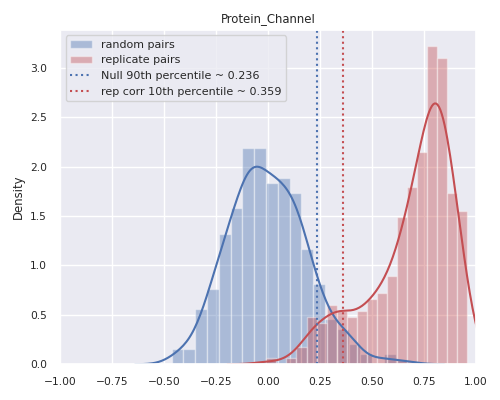

/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/process/replicate_correlation.py:96: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/process/replicate_correlation.py:105: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

np NonProtein_Channels


<IPython.core.display.Javascript object>


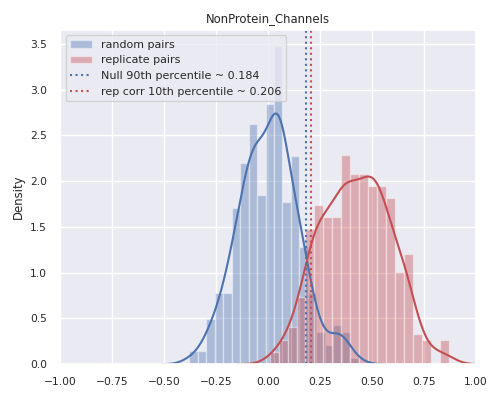

/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/process/replicate_correlation.py:96: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/process/replicate_correlation.py:105: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

In [189]:
from singlecell.process.replicate_correlation import replicate_null_corr_coefs
from singlecell.process import normalize_funcs

scal_status='standardized_perPlate'


df_rep_level=df_batch_plates_annot[df_batch_plates_annot['Metadata_Sample_Unique']!='516 - TC'].reset_index(drop=True)

if scal_status=='standardized_perPlate':
    df_rep_level_scaled=normalize_funcs.standardize_per_catX(df_rep_level,'Metadata_Plate',cpFeats_P+cpFeats_NP).copy();
# df_rep_level_scaled = normalize_funcs.standardize_df_columns(df_rep_level,cpFeats_P+cpFeats_NP,'Standard')
else:
    df_rep_level_scaled = df_rep_level.copy()
    
    
    
nOfReps=df_rep_level_scaled.groupby(['Metadata_Sample_Unique']).size().reset_index()
pairWithReplicates=nOfReps.loc[nOfReps[0]!=1,:].reset_index()['Metadata_Sample_Unique']#.groupby([0]).size()

# scal_status=df_rep_level_scaled['normalization'].unique()[0]
# zscor_status=df_rep_level_scaled['zscored'].unique().astype(str)[0]
# zscor_status='nan'
# if not np.isnan(df_rep_level_scaled['zscored'].unique()[0])

saveDir=rootDir+'/results/replicate_corr_curves/'+batch
# 
os.makedirs(saveDir, exist_ok=True)

pertColName='Metadata_Sample_Unique'
repCor4impactList=[]
for f,ch,t in zip([cpFeats_P,cpFeats_NP],['p','np'],['Protein_Channel','NonProtein_Channels']):
    print(ch,t)
#     t2=t+', '+scal_status+', zscored: '+zscor_status
    fh_2save,repCorrDf=replicate_null_corr_coefs(df_rep_level_scaled,pertColName,f,1,title=t,hist_bins=20)
    fh_2save.savefig(saveDir+'/'+ch+'_'+profile_type+'.png')
    repCorrDf=repCorrDf.add_suffix('_'+ch)
    repCor4impactList.append(repCorrDf);
    
repCorr_df_avg=pd.concat(repCor4impactList,axis=1).reset_index().rename(columns={'index':pertColName})
repCorr_df_avg.to_csv(saveDir+'/'+scal_status+'_'+profile_type+'.csv',index=False)
df_rep_level_scaled=pd.merge(df_rep_level_scaled,repCorr_df_avg,how='left',on=pertColName)

In [206]:
repCorr_df_avg

,Metadata_Sample_Unique,RepCor_p,Rand90Perc_p,Rep10Perc_p,RepCor_np,Rand90Perc_np,Rep10Perc_np
0,ACSF3,0.733033,0.236407,0.359196,0.304979,0.183632,0.206219
1,ACSF3 Ala197Thr,0.571281,0.236407,0.359196,0.201265,0.183632,0.206219
2,ACSF3 Thr358Ile,0.630992,0.236407,0.359196,0.365734,0.183632,0.206219
3,ACSF3 Met198Arg,0.566512,0.236407,0.359196,0.217637,0.183632,0.206219
4,ACSF3 Glu359Lys,0.51067,0.236407,0.359196,0.246498,0.183632,0.206219
...,...,...,...,...,...,...,...
341,FAM161A Leu269Arg,0.208519,0.236407,0.359196,0.477677,0.183632,0.206219
342,FAM187A,0.488763,0.236407,0.359196,0.229145,0.183632,0.206219
343,FASLG,0.34177,0.236407,0.359196,0.373998,0.183632,0.206219
344,FBP1,0.836435,0.236407,0.359196,0.392719,0.183632,0.206219


#### 7. Calculate WT-MT impact scores and save
- Approach 1: average replicate level profiles and score treatment level profiles
- Approach 2: calculate impact scores per plate

In [193]:
# Approach 1

# df_rep_level_scaled['Gene-dose']=df_rep_level_scaled['Gene']+'-'+df_rep_level_scaled['vTitre'].astype(str)
wt_mt_cols=['Gene','Metadata_Sample_Unique']
impact_scores_trt_profs = impactscore.impact_score_wt_mt(df_rep_level_scaled,repCorr_df_avg,[cpFeats_P,cpFeats_NP],\
                                                        wt_mt_cols);
   
saveDir=rootDir+'/results/Impact-Scores/Method-MeanProfiles/'+batch
os.makedirs(saveDir, exist_ok=True)
impact_scores_trt_profs.to_csv(saveDir+'/impact_scores_trt_'+today.strftime("%Y%m%d")+'.csv',index=False)

In [201]:
impact_scores_trt_profs.columns

Index(['Metadata_Sample_Unique', 'cc_p', 'Gene', 'wt_RepCor_p', 'cc_np',
       'wt_RepCor_np', 'RepCor_p', 'Rand90Perc_p', 'Rep10Perc_p', 'RepCor_np',
       'Rand90Perc_np', 'Rep10Perc_np'],
      dtype='object')

In [202]:
# 
print(impact_scores_trt_profs[['Gene','Metadata_Sample_Unique', 'cc_p', 'wt_RepCor_p', 'cc_np',\
       'wt_RepCor_np', 'RepCor_p', 'Rand90Perc_p', 'Rep10Perc_p', 'RepCor_np',\
       'Rand90Perc_np', 'Rep10Perc_np']].to_markdown())

|     | Gene    | Metadata_Sample_Unique   |        cc_p |   wt_RepCor_p |      cc_np |   wt_RepCor_np |    RepCor_p |   Rand90Perc_p |   Rep10Perc_p |   RepCor_np |   Rand90Perc_np |   Rep10Perc_np |
|----:|:--------|:-------------------------|------------:|--------------:|-----------:|---------------:|------------:|---------------:|--------------:|------------:|----------------:|---------------:|
|   0 | DOLK    | DOLK Tyr441Ser           |  0.812154   |      0.303609 |  0.549158  |      0.246678  |  0.459496   |       0.236407 |      0.359196 |  0.32718    |        0.183632 |       0.206219 |
|   1 | EMD     | EMD Ala56Thr             |  0.400925   |      0.663506 |  0.141576  |      0.108136  |  0.541148   |       0.236407 |      0.359196 |  0.638897   |        0.183632 |       0.206219 |
|   2 | EMD     | EMD Asp72Val             |  0.496056   |      0.663506 |  0.261438  |      0.108136  |  0.305962   |       0.236407 |      0.359196 |  0.265102   |        0.183632 |       0.2062

In [204]:
impactfull_ratio_p=impact_scores_trt_profs[impact_scores_trt_profs['cc_p']<impact_scores_trt_profs['Rep10Perc_p']].shape[0]/impact_scores_trt_profs.shape[0]

impactfull_ratio_np=impact_scores_trt_profs[impact_scores_trt_profs['cc_np']<impact_scores_trt_profs['Rep10Perc_np']].shape[0]/impact_scores_trt_profs.shape[0]

In [205]:
impactfull_ratio_p, impactfull_ratio_np

(0.39669421487603307, 0.40082644628099173)

In [160]:
# Approach 2
impact_scores_perplate = impactscore.impact_score_wt_mt_perplate(df_rep_level_scaled,repCorr_df_avg,[cpFeats_P,cpFeats_NP])

saveDir=rootDir+'/results/Impact-Scores/Method-MeanProfiles/'+batch
os.makedirs(saveDir, exist_ok=True)
impact_scores_perplate.to_csv(saveDir+'/impact_scores_perplate_'+today.strftime("%Y%m%d")+'.csv',index=False)

In [169]:
impact_scores_perplate_avg = impact_scores_perplate[['Metadata_Sample_Unique','cc_p','cc_np']].groupby('Metadata_Sample_Unique').mean()

In [171]:
impact_scores_perplate_avg

,cc_p,cc_np
Metadata_Sample_Unique,,
ACSF3 Ala197Thr,-0.200065,0.494246
ACSF3 Arg10Trp,0.201867,0.493569
ACSF3 Arg471Trp,-0.288701,0.041416
ACSF3 Arg558Trp,-0.231973,0.028173
ACSF3 Asp236Asn,-0.042616,-0.108074
...,...,...
FADD Cys105Trp,0.242791,0.086228
FAM161A Leu269Arg,0.368134,0.054186
FBP1 Ala177Asp,-0.210286,0.086536


In [172]:
impact_scores_perplate_avg[impact_scores_perplate_avg['cc_p']<0.34].shape[0]/impact_scores_perplate_avg.shape[0]

0.45041322314049587

In [157]:
impact_scores_perplate[impact_scores_perplate['cc_np']<0.19].shape[0]/impact_scores_perplate.shape[0]

0.4035812672176309

In [139]:
# genes_variant_size
# df_rep_level_scaled[['Gene','Metadata_Sample_Unique']]
set(genes_variant_size[genes_variant_size[0]>1].Gene.tolist())

{'ACSF3',
 'AGXT',
 'AIPL1',
 'ALAS2',
 'AMPD2',
 'AP2S1',
 'APOA1',
 'ASNS',
 'BAG3',
 'BCL10',
 'BFSP2',
 'CA8',
 'CDC73',
 'CDKN1A',
 'CFP',
 'CHN1',
 'CLCNKA',
 'CLDN19',
 'COMP',
 'COQ8A',
 'CORO1A',
 'CRADD',
 'CREB1',
 'CRYAB',
 'CSNK1D',
 'CTH',
 'CTRC',
 'DCX',
 'DES',
 'DIABLO',
 'DOLK',
 'EFHC1',
 'EIF2B4',
 'EMD',
 'FA2H',
 'FADD',
 'FAM161A',
 'FBP1',
 'IMPDH1'}

In [140]:
set(df_rep_plate.Metadata_Sample_Unique.unique().tolist())

{'ACSF3 ',
 'ACSF3 Ala197Thr',
 'ACSF3 Arg10Trp',
 'ACSF3 Arg471Trp',
 'ACSF3 Arg558Trp',
 'ACSF3 Asp236Asn',
 'ACSF3 Asp457Asn',
 'ACSF3 Glu359Lys',
 'ACSF3 Gly119Asp',
 'ACSF3 Gly225Arg',
 'ACSF3 Ile200Met',
 'ACSF3 Met198Arg',
 'ACSF3 Met266Val',
 'ACSF3 Pro243Leu',
 'ACSF3 Pro285Leu',
 'ACSF3 Ser431Tyr',
 'ACSF3 Thr358Ile',
 'ACTB ',
 'ACTN1 ',
 'ACY1 ',
 'ADIPOQ ',
 'AGXT ',
 'AGXT Ala186Val',
 'AGXT Ala210Pro',
 'AGXT Ala248Ser',
 'AGXT Ala248Val',
 'AGXT Ala280Val',
 'AGXT Ala295Thr',
 'AGXT Ala85Asp',
 'AGXT Arg111Gln',
 'AGXT Arg118Cys',
 'AGXT Arg197Gln',
 'AGXT Arg289His',
 'AGXT Arg301Cys',
 'AGXT Arg36Cys',
 'AGXT Arg381Lys',
 'AGXT Asn22Ser',
 'AGXT Asp129His',
 'AGXT Asp201Asn',
 'AGXT Asp341Glu',
 'AGXT Glu274Asp',
 'AGXT Gly116Arg',
 'AGXT Gly156Arg',
 'AGXT Gly161Arg',
 'AGXT Gly161Ser',
 'AGXT Gly41Arg',
 'AGXT Gly41Glu',
 'AGXT Gly82Arg',
 'AGXT Ile202Asn',
 'AGXT Ile279Met',
 'AGXT Ile279Thr',
 'AGXT Ile340Met',
 'AGXT Leu298Pro',
 'AGXT Lys12Arg',
 'AGXT Met195Leu

In [129]:
impact_scores_df_chs_ls=[]
featColNames_ls=[cpFeats_P,cpFeats_NP]
plates=df_rep_level_scaled.Metadata_batch_Plate.unique()

for f,ch in zip(featColNames_ls,['p','np']):
    impact_scores_df_ls=[]
    for p in plates:
        df_rep_plate=df_rep_level_scaled[df_rep_level_scaled['Metadata_batch_Plate']==p].reset_index(drop=True)
        impact_corr_mat=df_rep_plate.groupby(['Gene','Metadata_Sample_Unique']).mean()[f].T.corr()

        genes_variant_size=impact_corr_mat.groupby('Gene').size().reset_index()
        genes_with_variant=list(set(genes_variant_size[genes_variant_size[0]>1].Gene.tolist()) &\
                                set(df_rep_plate.Metadata_Sample_Unique.unique().tolist()))

        for g in genes_with_variant:
            per_gene_df=impact_corr_mat.loc[g][g][g].reset_index()
#             sfgsg
        #     per_gene_df['Gene']=per_gene_df.columns[1]
            per_gene_df['Gene']=g
            per_gene_df['Metadata_batch_Plate']=p

            impact_scores_df_ls.append(per_gene_df.rename(columns={g:'cc_'+ch}))

#         fsdfgsfs
    if impact_scores_df_ls:
        impact_scores_df=pd.concat(impact_scores_df_ls,ignore_index=True)
#             impact_scores_df['Metadata_batch_Plate']=p
        impact_scores_df_chs_ls.append(impact_scores_df)

impact_scores_df_chs=pd.concat(impact_scores_df_chs_ls,axis=1).T.drop_duplicates().T

ValueError: No objects to concatenate

In [ ]:
# print(impact_scores_trt_profs.to_markdown())

In [ ]:
control_type='negcon'
neg_con_unq=annot_df.loc[(annot_df['control_type']==control_type) &(annot_df['vTitre']==6),\
                         'Metadata_Sample_Unique'].tolist()
control_type='poscon'
pos_con_unq=annot_df.loc[(annot_df['control_type']==control_type) &(annot_df['vTitre']==6),\
                         'Metadata_Sample_Unique'].tolist()

In [ ]:
print(impact_scores_trt_profs.to_markdown())

In [ ]:
annot_df[(annot_df['control_type']=='negcon') &(annot_df['vTitre']==6)].groupby('Metadata_Sample_Unique').size()

In [ ]:
print(impact_scores_trt_profs[impact_scores_trt_profs['Metadata_Sample_Unique'].isin(pos_con_unq)].to_markdown(index=False))

In [ ]:
print(repCorr_df_avg[repCorr_df_avg['Metadata_Sample_Unique'].isin(neg_con_unq)].to_markdown(index=False))

In [ ]:
# impact_scores_trt_profs
# repCorr_df_avg

In [ ]:
featColNames_ls=[cpFeats_P,cpFeats_NP]
impact_scores_df_chs_ls=[]
for f,ch in zip(featColNames_ls,['p','np']):
    impact_corr_mat=df_rep_level_scaled.groupby([wt_mt_cols[0],wt_mt_cols[1]]).mean()[f].T.corr()

    genes_variant_size=impact_corr_mat.groupby(wt_mt_cols[0]).size().reset_index()
    genes_with_variant=list(set(genes_variant_size.loc[genes_variant_size[0]>1,wt_mt_cols[0]].tolist()) &\
                            set(df_rep_level_scaled[wt_mt_cols[1]].unique().tolist()))
    impact_scores_df_ls=[]
    for g in genes_with_variant:
        per_gene_df=impact_corr_mat.loc[g][g][g].reset_index()
    #     per_gene_df['Gene']=per_gene_df.columns[1]
        per_gene_df[wt_mt_cols[0]]=g
        per_gene_df['wt_RepCor_'+ch]=repCorr_df_avg.loc[repCorr_df_avg[wt_mt_cols[1]]==g,'RepCor_'+ch].values[0]

        impact_scores_df_ls.append(per_gene_df.rename(columns={g:'cc_'+ch}))

    impact_scores_df=pd.concat(impact_scores_df_ls,ignore_index=True)
    impact_scores_df_chs_ls.append(impact_scores_df)

impact_scores_df_chs=pd.concat(impact_scores_df_chs_ls,axis=1).T.drop_duplicates().T

In [ ]:
# impact_corr_mat.loc[g][g]
df_rep_level_scaled[['Gene-dose','Metadata_Sample_Unique','vTitre']]

In [ ]:
# pd.concat(repCor4impactList,axis=1).reset_index()

In [ ]:
results_df.Variant.unique()

In [ ]:
palette = sns.color_palette("Paired",20)

In [ ]:
palette[1]